# Importing data

In [1]:
import pandas as pd

In [2]:
routes_df = pd.read_csv("data/routes.csv")
airports_df = pd.read_csv("data/airports.csv")

In [3]:
airports_by_iata_df = airports_df.groupby("IATA")

In [4]:
airports_by_longtitude_df = airports_df.groupby("Longitude")
airports_by_lattitude_df = airports_df.groupby("Latitude")

# Creating a directed multigraph

In [5]:
import networkx as nx

In [6]:
airport_nodes = list(airports_by_iata_df.groups)

In [7]:
#Ordering matches source and destination airport.
airport_src = list(routes_df["Source airport"])
airport_dest = list(routes_df["Destination airport"])

In [8]:
airport_routes_digraph = nx.MultiDiGraph()

airport_routes_digraph.add_nodes_from(airport_nodes)

#Due to some routes having an invalid source/destination, due to the airport not existing
#in the airport database, these routes are removed.
edges = [(airport_src[i],airport_dest[i]) for i in range(len(airport_src))
        if airport_src[i] in airport_nodes and airport_dest[i] in airport_nodes]

airport_routes_digraph.add_edges_from(edges);

# Plotting the graph

In [9]:
import matplotlib.pyplot as plt

In [10]:
def getLongitudeForIATA(df,IATA):
    result = list(df.loc[df['IATA'] == IATA]["Longitude"])
    if(len(result) > 0):
        return result[0]
    else:
        return 0

def getLatitudeForIATA(df,IATA):
    result = list(df.loc[df['IATA'] == IATA]["Latitude"])
    if(len(result) > 0):
        return result[0]
    else:
        return 0


In [11]:
positions = {}

for node in airport_routes_digraph.nodes:
    positions.update({node:(getLongitudeForIATA(airports_df,node),getLatitudeForIATA(airports_df,node))})    


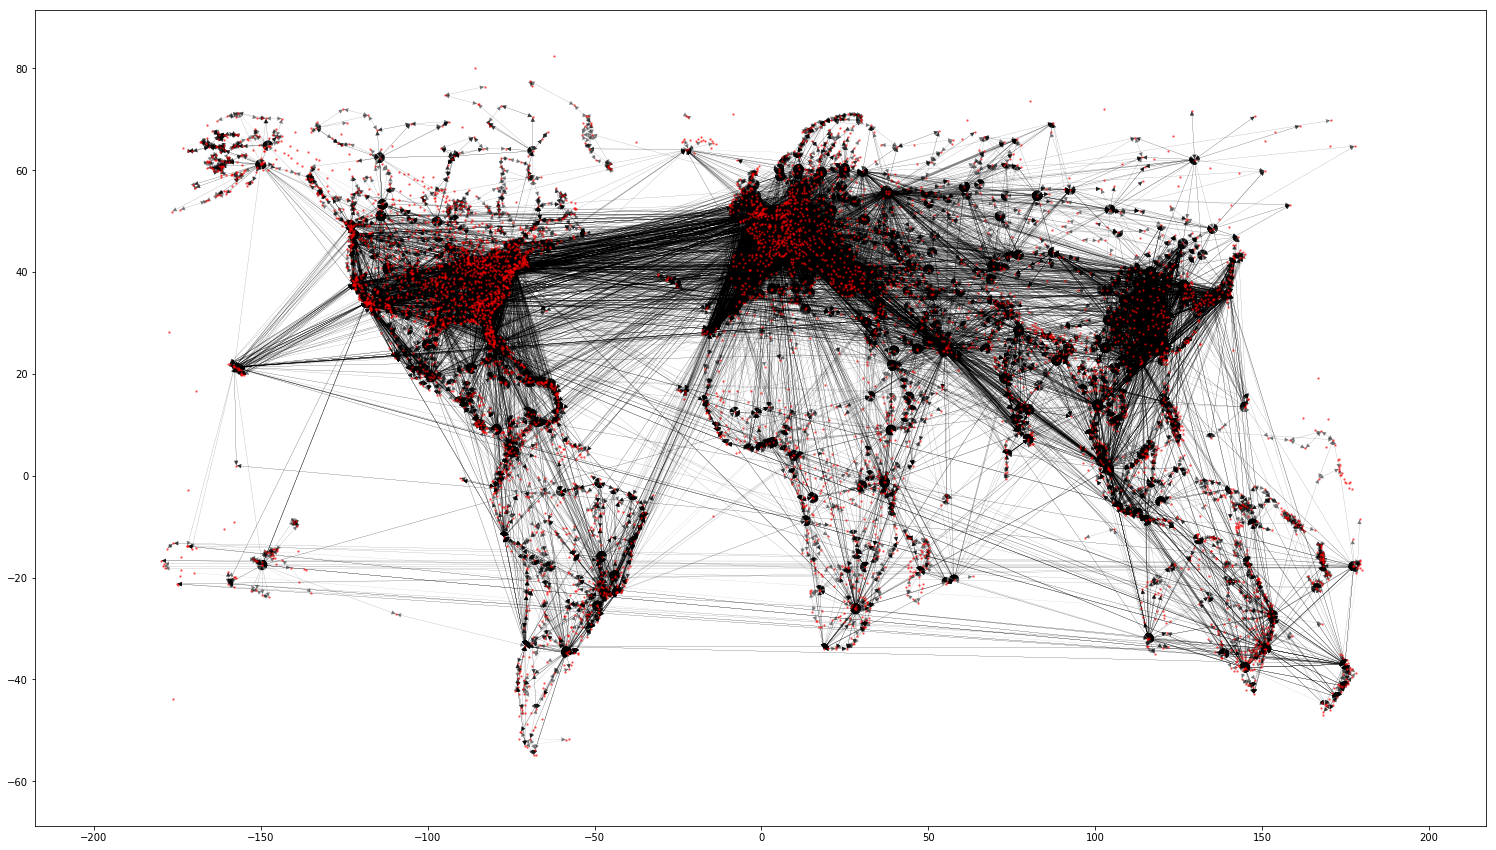

In [12]:
fig = plt.figure(figsize=(26,15))
nx.draw_networkx(airport_routes_digraph, positions, 
                 width=0.1,alpha=0.5,node_size=2,with_labels=False, 
                 ax=fig.add_subplot(111))

fig.savefig("output/airportgraph.png", transparent=True, bbox_inches='tight')

In [13]:
len(airport_routes_digraph.nodes)

5634

In [14]:
len(airport_routes_digraph.edges)

65836

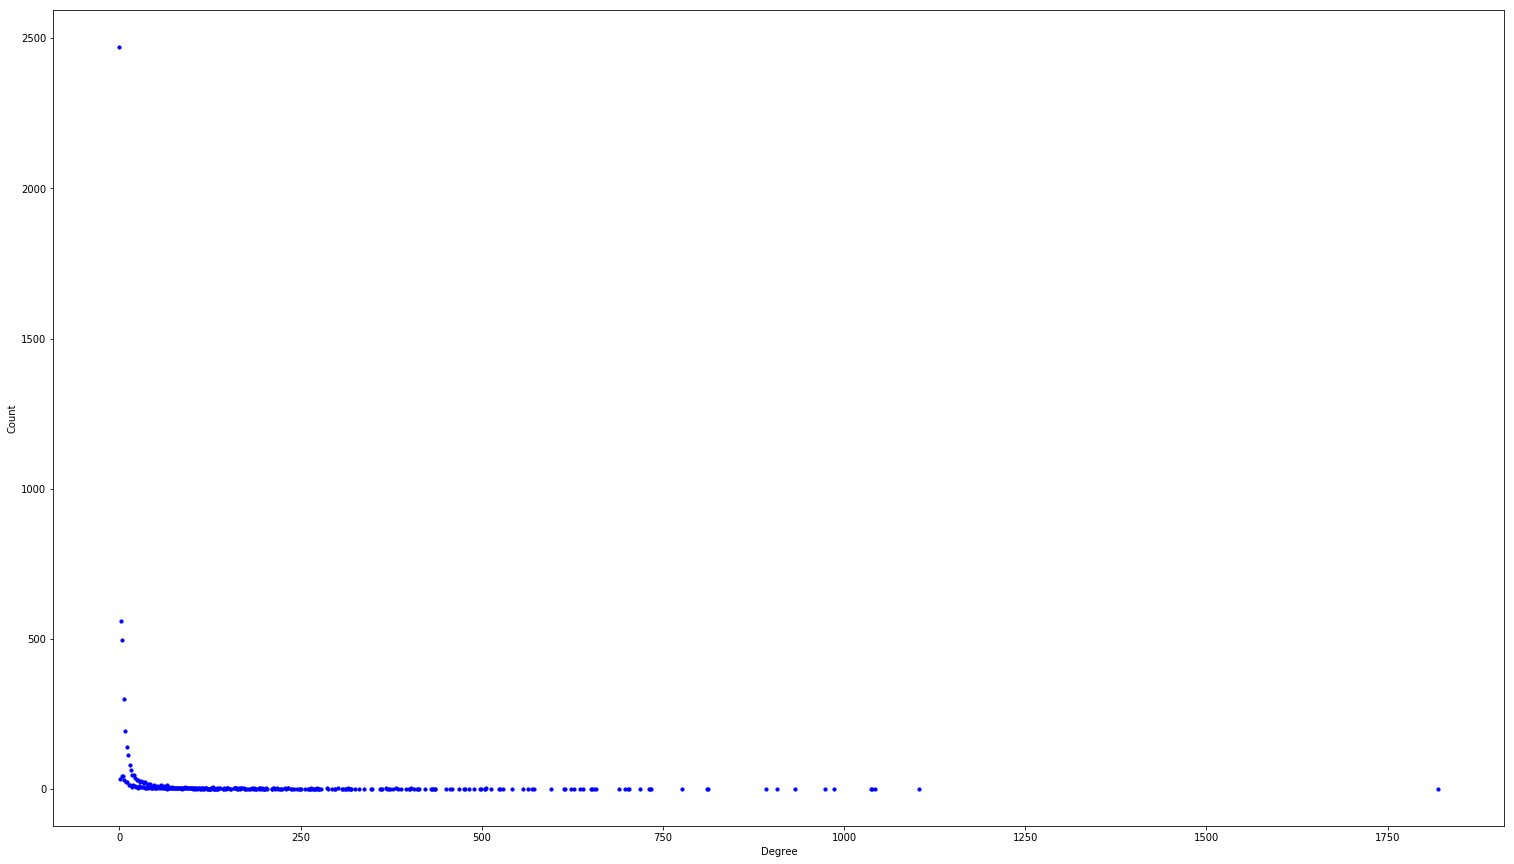

In [15]:
import collections

degreeforeach = sorted([d for n,d in airport_routes_digraph.degree], reverse=True)
degreeCount = collections.Counter(degreeforeach)
degrees, count = zip(*degreeCount.items())
fig = plt.figure(figsize=(26,15))
plt.scatter(degrees, count, s=10, color='b')
plt.ylabel("Count")
plt.xlabel("Degree")

fig.savefig('output/regularplot.png', bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

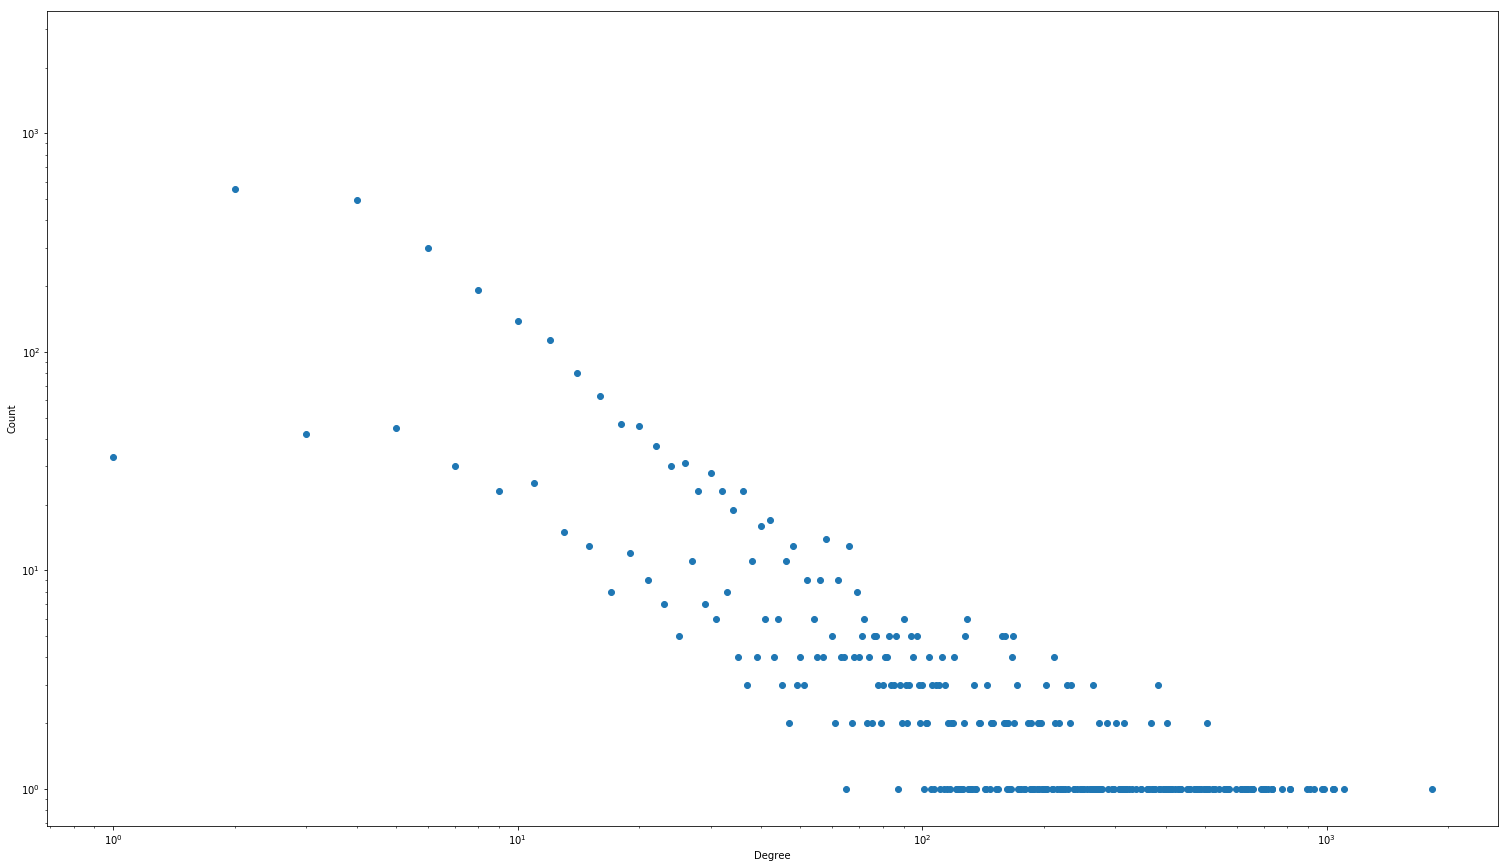

In [16]:
plt.clf()
fig = plt.figure(figsize=(26,15))
plt.loglog(degrees, count,'o')
plt.ylabel("Count")
plt.xlabel("Degree")

fig.savefig('output/powerlawplot.png', bbox_inches='tight')

# Community Detection

**Best Community Partition**

In [17]:
import community
from collections import Counter

In [18]:
community_partition = community.best_partition(airport_routes_digraph.to_undirected(),resolution=1.0)

In [19]:
print(community.modularity(community_partition,airport_routes_digraph.to_undirected()))

0.261486532742


In [20]:
countercoms = Counter(community_partition.values())
print("Top ten biggest communities out of " + str(len(community_partition)) + " communities:")
print(sorted(countercoms.values()))[-10:]

Top ten biggest communities out of 5634 communities:
[28, 130, 143, 163, 192, 288, 374, 417, 585, 732]


As we can see, the best community partition is a rather random one, which consists of a few communities containing many airports, but many communities with few airports. 
It would make sense that many of the larger airports that are interconnected would share the same community, e.g. many of larger airports in Europe and North America, as it can be seen from the plots that Europe and North America are especially well connected. It could also make sense that perhaps less connected areas in Afria and South America could create their own community, but it seems to be the case that some of the airports of less connected areas join the larger communities by just having a very few amount of connections to these highly connected areas, e.g. Europe.

The modularity for the best partition is 0.26, which is postive, but still sub-optimal. Considering that most airports are likely to be connected to another well connected airport, if it isn't well connected itself, it makes sense that the modularity isn't very high.

In [21]:
values = [community_partition.get(node) for node in airport_routes_digraph.nodes()]

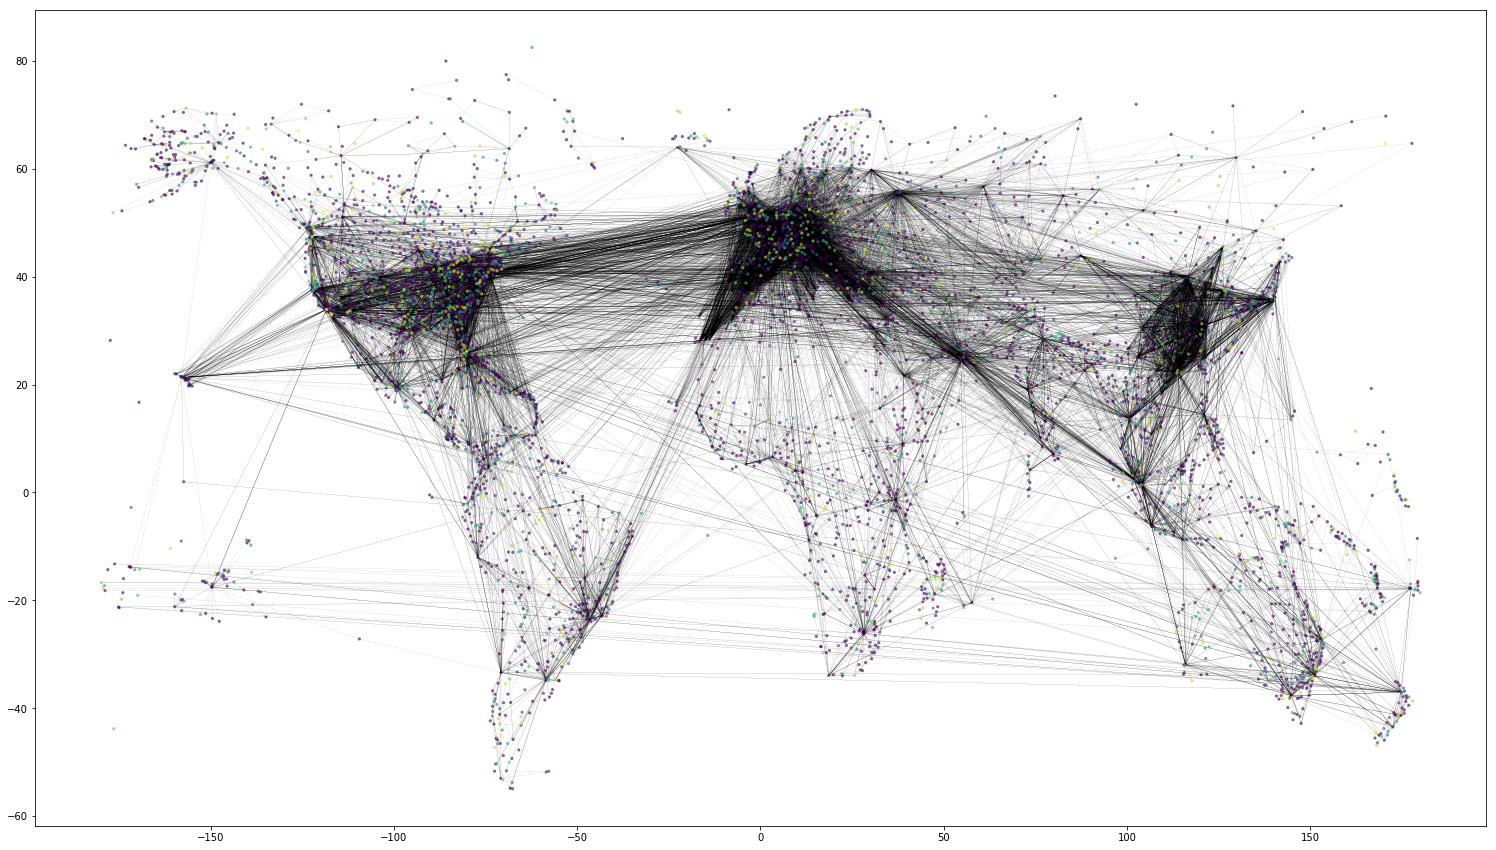

In [22]:
fig = plt.figure(figsize=(26,15))
nx.draw_networkx(airport_routes_digraph.to_undirected(), positions, 
                 width=0.1,alpha=0.5,node_size=5,with_labels=False, 
                 node_color = values, ax=fig.add_subplot(111))

fig.savefig("output/airportgraph_communities.png", transparent=True, bbox_inches='tight')

## Communities by Continent

**Preparing the data**

In [23]:
countriescontinents_df = pd.read_csv("data/CountriesContinents.csv")

In [24]:
countriescontinents_df.set_index(['Country','Continent']);

In [25]:
airports_continents = airports_df.merge(countriescontinents_df,on="Country",how="inner")

In [26]:
airports_continents_by_continent = airports_continents.groupby("Continent")
continents = list(airports_continents_by_continent.groups)


In [27]:
eur_df = list(airports_continents.loc[airports_continents['Continent'] == 'Europe'].groupby('IATA').groups);
oce_df = list(airports_continents.loc[airports_continents['Continent'] == 'Oceania'].groupby('IATA').groups);
afr_df = list(airports_continents.loc[airports_continents['Continent'] == 'Africa'].groupby('IATA').groups);
asia_df = list(airports_continents.loc[airports_continents['Continent'] == 'Asia'].groupby('IATA').groups);
na_df = list(airports_continents.loc[airports_continents['Continent'] == 'North America'].groupby('IATA').groups);
sa_df = list(airports_continents.loc[airports_continents['Continent'] == 'South America'].groupby('IATA').groups);

In [28]:
def calculateLC(graph,community_df):
    lc = 0
    for node in list(graph.nodes()):
        if node in community_df:
            lc += len([i for i in graph.neighbors(node) if i in community_df])
        
    return lc/2.0

def calculateKC(graph,community_df):
    return sum([graph.degree(node) for node in community_df])
    
def Mc(G,commmunity_df):
    return (calculateLC(G,commmunity_df)/len(G.edges()))-(calculateKC(G,commmunity_df)/(2*len(G.edges())))**2


**Calculating modularity**

In [29]:
#['Europe', 'Oceania', 'Africa', 'Asia', 'North America', 'South America']

modularity = Mc(airport_routes_digraph,eur_df) + Mc(airport_routes_digraph,oce_df) + Mc(airport_routes_digraph,afr_df) + Mc(airport_routes_digraph,asia_df) + Mc(airport_routes_digraph,na_df) + Mc(airport_routes_digraph,sa_df)

In [30]:
modularity 

0.23643599246612798

**Commenting on modularity**

When dividing the different continents into different communities, a modularity that is almost as high as the optimal community partition modularity. Even though the modularity is not very high, i.e. sub-optimal, it is positive that using continents as communities is close to the best possible community partition. 

It would make sense that partitioning by continent would create a sub-optimal community partition. Continents tend to have a fair amount of flights going within the continent, due to the physical size of the continents. This is also visible in the various plots. There are however still many intercontinental flights, which heavily lowers the modularity which is also why it is hard to find a good community partition. The different airports around the world are simply very well interconnected.

**Community plot**

In [31]:
nodeColors = []
for node in airport_routes_digraph.nodes:
    continent = list(airports_continents.loc[airports_continents['IATA'] == node]['Continent'])[0]
    
    if continent == 'Asia':
        nodeColors.append('red')
    elif continent == 'Europe':
        nodeColors.append('blue')
    elif continent == 'Oceania':
        nodeColors.append('cyan')
    elif continent == 'Africa':
        nodeColors.append('pink')
    elif continent == 'North America':
        nodeColors.append('green')
    elif continent == 'South America':
        nodeColors.append('yellow')    
    else:
        nodeColors.append('brown')

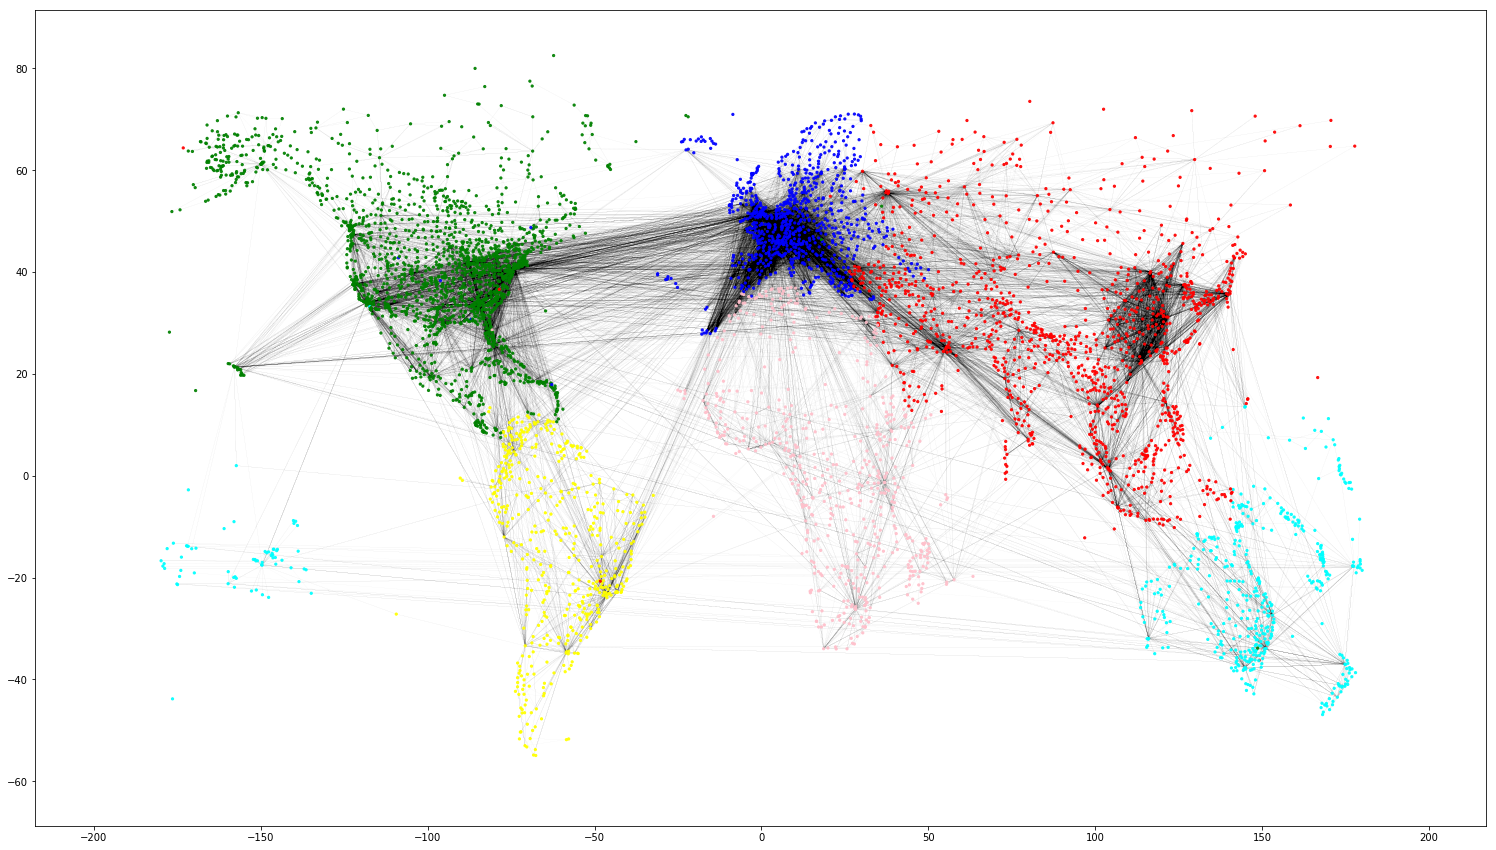

In [32]:
fig = plt.figure(figsize=(26,15))
nx.draw_networkx(airport_routes_digraph, positions, 
                 width=0.01,alpha=0.9,node_size=5,with_labels=False, 
                 node_color = nodeColors, ax=fig.add_subplot(111),arrowstyle='-')

fig.savefig("output/airportgraph_continent_communities.png", transparent=True, bbox_inches='tight')

# Communities by Countries

**Calculating modularity**

In [33]:
countries = list(airports_df.groupby('Country').groups)

In [34]:
country_dfs = []

In [35]:
for country in countries:
    country_dfs.append((country,list(airports_df.loc[airports_df['Country'] == country].groupby('IATA').groups)))

In [36]:
country_by_modularity =  [(c[0],Mc(airport_routes_digraph,c[1])) for c in country_dfs]
country_com_modularity = sum([Mc(airport_routes_digraph,c[1]) for c in country_dfs])

In [37]:
print(country_com_modularity)

0.130468132936


In [38]:
countries_sort_by_mod = sorted(country_by_modularity,key = lambda (k,v):(v,k),reverse=True)
top_10_country_mod = countries_sort_by_mod[:10]
bot_10_country_mod = countries_sort_by_mod[-10:]

print("Top 10:")
print(top_10_country_mod)
print(" ")
print("Bottom 10:")
print(bot_10_country_mod)

Top 10:
[('United States', 0.04124643052433319), ('China', 0.020011847621362173), ('Canada', 0.006212406586062337), ('Brazil', 0.005323834983899386), ('Russia', 0.005141563886019807), ('Australia', 0.0033492314235372745), ('Japan', 0.002642930919253904), ('India', 0.0026049577738623247), ('Mexico', 0.002430281305061061), ('France', 0.002369524272434534)]
 
Bottom 10:
[('Belarus', 0.0), ('Barbados', 0.0), ('Bahrain', 0.0), ('Aruba', 0.0), ('Armenia', 0.0), ('Antigua and Barbuda', 0.0), ('Antarctica', 0.0), ('Anguilla', 0.0), ('American Samoa', 0.0), ('Albania', 0.0)]


**Commenting on modularity**

The modularity when creating communities based on countries is very low. This makes sense, since most countries are not very big and do not have a lot of domestic flights. Therefore many of outgoing flights from those countries are international. The bigger countries should be more ideal as a community, since their vast area would imply more domestic flights, but there aren't that many very large countries and  they too have large international airports connecting the country to other contintents. This is also exactly what can be noted by looking at the top 10 and bottom 10 countries by their contribution to the modularity of the whole community. The bottom 10 are smaller countries, and in many cases small islands, which further proves the above statement.

**Community plot**

In [39]:
countrylabels = []
for node in airport_routes_digraph.nodes():
    countrylabels.append(countries.index(list(airports_df.loc[airports_df['IATA'] == node]['Country'])[0]))

In [40]:
colors = list(map(plt.cm.get_cmap('hsv', len(set(countries))+1),countrylabels))

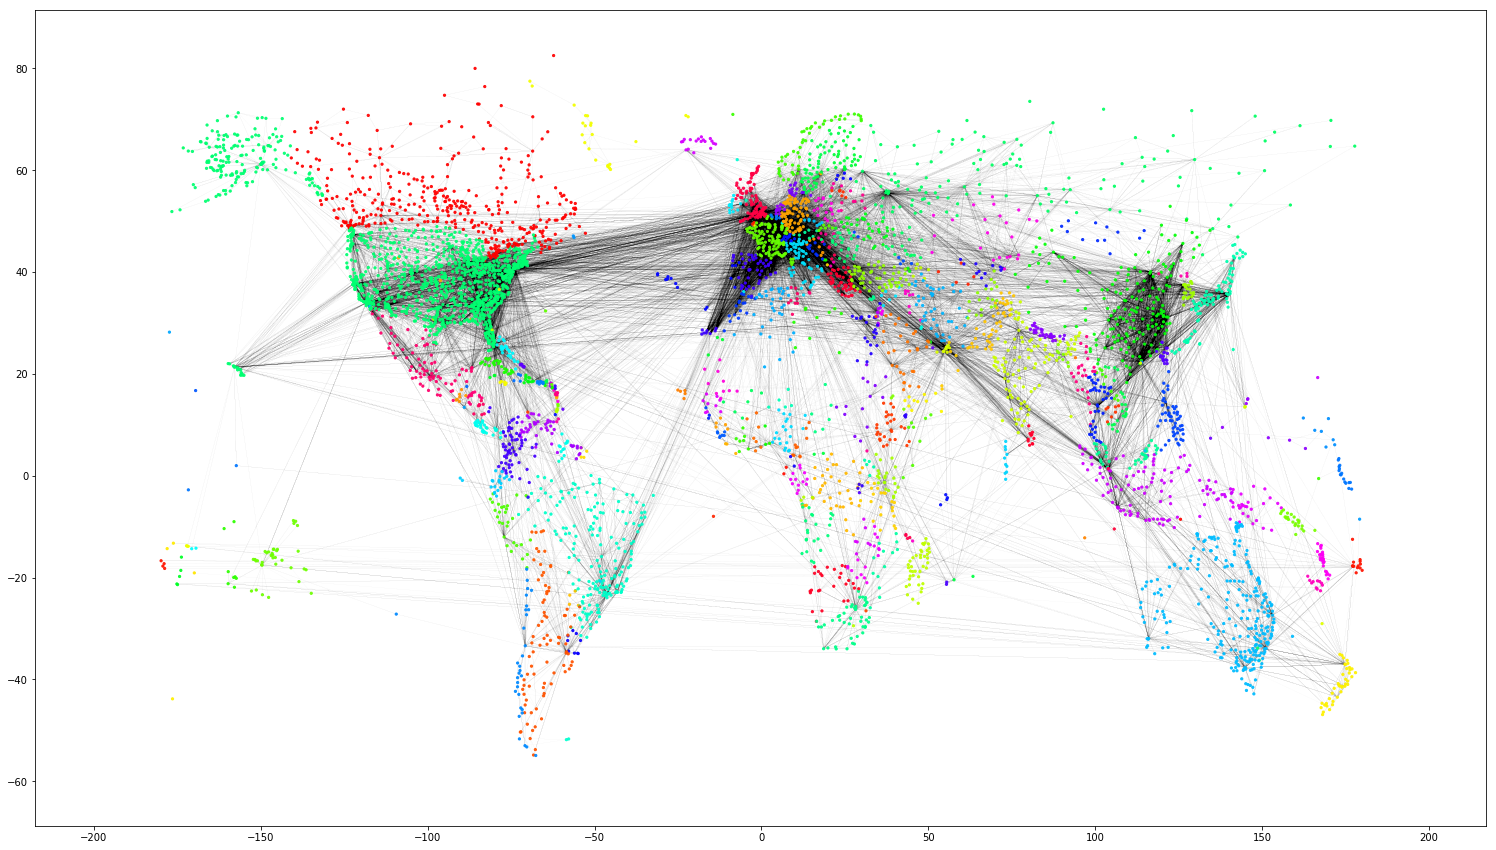

In [41]:
fig = plt.figure(figsize=(26,15))
nx.draw_networkx(airport_routes_digraph, positions, 
                 width=0.01,alpha=0.9,node_size=5,with_labels=False, 
                 node_color = colors, ax=fig.add_subplot(111),arrowstyle='-')

fig.savefig("output/airportgraph_country_communities.png", transparent=True, bbox_inches='tight')

# Further Community Analysis

It was chosen also to analyze, whether hub airports tend to connect communities together. Here we're keeping the community partition using continents in mind, since it makes more sense to analyze that partition, than the best partition which at a quick glance is nonsensical.

In [42]:
#The following hubs are found based on degree.
hubs = ['Hartsfield Jackson Atlanta International Airport',"Chicago O'Hare International Airport",
        'Beijing Capital International Airport','Charles de Gaulle International Airport',
        'London Heathrow Airport','Los Angeles International Airport',
        'Frankfurt am Main International Airport','Amsterdam Airport Schiphol',
        'Dallas Fort Worth International Airport','John F Kennedy International Airport']

In [43]:
nodesizes = []
nodeColors = []

#Hubs are colored xxx and a given a larger size than the remaining airports.
for node in airport_routes_digraph.nodes:
    continent = list(airports_continents.loc[airports_continents['IATA'] == node]['Continent'])[0]
    if (list(airports_df.loc[airports_df['IATA'] == node]['Name'])[0] in hubs):
            nodeColors.append('red')
            nodesizes.append(100)
    else:        
        nodesizes.append(2)
        if continent == 'Asia':
            nodeColors.append('purple')
        elif continent == 'Europe':
            nodeColors.append('blue')
        elif continent == 'Oceania':
            nodeColors.append('cyan')
        elif continent == 'Africa':
            nodeColors.append('pink')
        elif continent == 'North America':
            nodeColors.append('green')
        elif continent == 'South America':
            nodeColors.append('yellow')    
        else:
            nodeColors.append('brown')

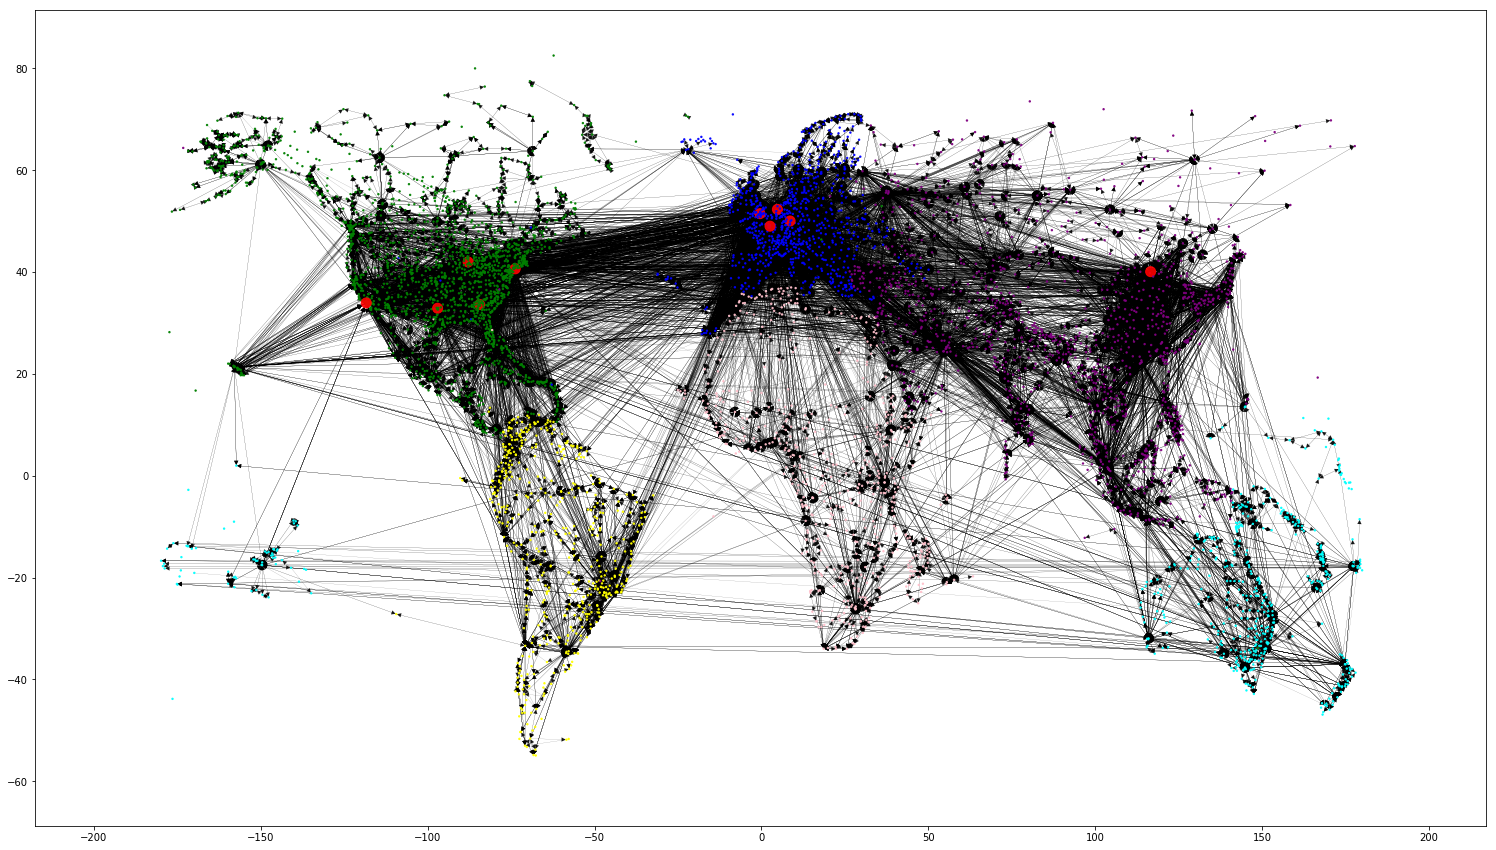

In [46]:
fig = plt.figure(figsize=(26,15))
nx.draw_networkx(airport_routes_digraph, positions, 
                 width=0.1,alpha=0.9,node_color=nodeColors,node_size=nodesizes,with_labels=False, 
                 ax=fig.add_subplot(111))

fig.savefig("output/airportgraph_with_high_degree_hubs.png", transparent=True, bbox_inches='tight')

Considering the plot above, the red plots are the hubs that were defined. What could be considered is whether or not the hubs tend to be links between communities. This has to be the case. Due to the fact that a given node is a hub, must also indicate that this node will be connected communities together. It could be the case that the hub only connects with other nodes in the same community. However, in this case we're dealing with airports and when using continents as a partioning, it will lead to the hubs connecting communities together.

# Tweets sentiment

In [158]:
import nltk
from nltk.corpus import stopwords
from nltk import FreqDist
import string
import pickle
from wordcloud import WordCloud
from PIL import Image
import os
import pandas as pd
import numpy as np
import requests
from tqdm import tqdm_notebook as tqdm
import math
import imageio

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('dark_background')
plt.style.use('seaborn-deep')

from typing import List

data_path = 'data'

Retreive the airport data from https://openflights.org/data.html.

In [2]:
airports_filename = 'airports.csv'
routes_filename = 'routes.csv'

In [3]:
airports = pd.read_csv(os.path.join(data_path, 'airports.csv'))
airports.set_index('Airport Id', inplace=True)

In [4]:
airports

Name                City  \
Airport Id                                                                    
1                                        Goroka Airport              Goroka   
2                                        Madang Airport              Madang   
3                          Mount Hagen Kagamuga Airport         Mount Hagen   
4                                        Nadzab Airport              Nadzab   
5           Port Moresby Jacksons International Airport        Port Moresby   
6                           Wewak International Airport               Wewak   
7                                    Narsarsuaq Airport        Narssarssuaq   
8                               Godthaab / Nuuk Airport            Godthaab   
9                                 Kangerlussuaq Airport         Sondrestrom   
10                                       Thule Air Base               Thule   
11                                     Akureyri Airport            Akureyri   
12                                  Egilsstaðir Airport         Egilsstadir   
13                                 Hornafjörður Airport                Hofn   
14                                      Húsavík Airport             Husavik   
15                                   Ísafjörður Airport          Isafjordur   
16                       Keflavik International Airport            Keflavik   
17                               Patreksfjörður Airport      Patreksfjordur   
18                                    Reykjavik Airport           Reykjavik   
19                                 Siglufjörður Airport        Siglufjordur   
20                               Vestmannaeyjar Airport      Vestmannaeyjar   
21                              Sault Ste Marie Airport  Sault Sainte Marie   
22                       Winnipeg / St. Andrews Airport            Winnipeg   
23                    Halifax / CFB Shearwater Heliport             Halifax   
24                                  St. Anthony Airport         St. Anthony   
25                          Tofino / Long Beach Airport              Tofino   
26                                     Kugaaruk Airport           Pelly Bay   
27                                  Baie Comeau Airport         Baie Comeau   
28                                       CFB Bagotville          Bagotville   
29                                   Baker Lake Airport          Baker Lake   
30                               Campbell River Airport      Campbell River   
...                                                 ...                 ...   
12028                                    Kerang Airport                 NaN   
12029                                   Kempsey Airport                 NaN   
12030                                  Kingaroy Airport                 NaN   
12031                            Latrobe Valley Airport             Morwell   
12032                                   Mareeba Airport                 NaN   
12033                                   Ngukurr Airport                 NaN   
12034                                 Narromine Airport                 NaN   
12035                                Port Pirie Airport                 NaN   
12036                                  Smithton Airport                 NaN   
12037                                 Snake Bay Airport                 NaN   
12038                                   Stawell Airport                 NaN   
12039                                Tibooburra Airport                 NaN   
12040                                     Tumut Airport                 NaN   
12041                                Wangaratta Airport                 NaN   
12042                             Warracknabeal Airport                 NaN   
12043                                    Warren Airport                 NaN   
12044                                 West Sale Airport                Sale   
12045                              West Wyalong Airport        West Wyalong   
12046                 

## TF-IDF analysis of Twitter

The tweets have been retreived from twitter's API. The data we have collected can be found [here](https://1drv.ms/u/s!AoyV20xD2_Tx0vIuF0HGgFg-5CyaIw).
Every file coresponds to the id of an airport, and contain up to 100 of the latest tweets from the given airport (the dataset was generated on 2018-11-08).
As tweets can be multiline, each tweet is seperated by ';;;' in the files.

In [5]:
tweets = {
    row['Name']: ''.join(open(
        os.path.join(data_path, 'tweets', str(index)), 'r', encoding='utf-8'
    ).readlines())
    for index, row in airports.iterrows()
}

Each tweet is tokenized and cleaned to remove stopworld, punctuation, and blacklisted words, such as keywords used by twitter.

In [6]:
blacklisted_tokens = [
    'rt',
    'amp'
]
def tokenize(text: str, names: set = []) -> List[str]:
    sw = stopwords.words('english')
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = nltk.word_tokenize(text)
    tokens = [token for token in tokens
                  if token not in names
                  and token not in sw
                  and not token.isdigit()
                  and token not in blacklisted_tokens
         ]
    return tokens

In [7]:
%%capture cap --no-stderr
tokens = { airport: tokenize(document) for airport, document in tqdm(tweets.items()) }

In [8]:
def calculate_n_ts(tokens: list, documents: list) -> set:
    ''' Calculate the n_ts for a list of tokens given a list of documents
    '''
    return {
        word: sum(1 for document in documents if word in document)
           for word in set(tokens)
    }

As calculating how many documents each of the words occure in takes some time, we have cheated a little and saved the result. To optimize the calculations, we have transformed each of the documents into sets.

In [9]:
# tokens_set = { airport: set(document) for airport, document in tokens.items() }
# n_ts = { 
#     airport: calculate_n_ts(ts, tokens_set.values()) 
#     for airport, ts in tqdm(tokens.items())
# }
# with open(os.path.join(data_path, 'n_ts.data'), 'wb') as f:
#     pickle.dumb(f)

In [10]:
with open(os.path.join(data_path, 'n_ts.data'), 'rb') as f:
    n_ts = pickle.load(f)

Calculating the IDF can now be done using the following function.

In [11]:
def calculateIDF(nts: set, N: int, base=2) -> set:
    return { word: math.log(N / n_t, base)
        for word, n_t in nts.items()
    }

In [12]:
N = len(list(airports['Name']))
IDF = {
    airport: calculateIDF(n_ts[airport], N)
    for airport in tqdm(list(airports['Name']))
}

Calculate the TF_IDF

In [13]:
def calculateTF_IDF(tfs: set, IDFs: set) -> set:
    return {
        word: tf * IDFs[word]
        for word, tf in tfs.items()
    }

In [14]:
freq = { airport: FreqDist(ts) for airport, ts in tokens.items() }

In [15]:
TF_IDF = {
    airport: calculateTF_IDF(freq[airport], IDF[airport])
    for airport in tokens.keys()
}

The most used words in all of the documents:

In [16]:
all_tokens = [t for ts in tokens.values() for t in ts]

In [17]:
freqency_total = FreqDist(all_tokens)

## Word clouds

In [162]:
def drawWordCloud(text: str, title: str, mask: str = None):
    if mask:
        mask = np.array(Image.open(os.path.join('masks', mask)))
        
    wordcloud = WordCloud(
        collocations=False,
        mask=mask,
#         background_color='white',
        contour_width=3, 
        contour_color='steelblue'
        ).generate(text)
    fig, ax = plt.subplots(figsize=(16, 8))
#     ax.set_title(title)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    imageio.imwrite(f'output/{title}.png', np.array(wordcloud))
    plt.show()

In [164]:
combined_all_tokens = ' '.join(all_tokens)

In [165]:
drawWordCloud(combined_all_tokens, 'All tokens', 'Airplane_silhouette.png')

## Sentiment

To calculate the sentiment of each of the airports, we are using the data set created in [Temporal Patterns of Happiness and Information in a Global Social Network: Hedonometrics and Twitter](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752).
This data set contains over 10,000 individual words and their happiness score, which is generated by having many unique people rate each of the words and calculating a aggregated score based on this.

In [20]:
happiness = pd.read_csv(os.path.join(data_path, 'sentiment.csv'), delimiter='\t')

We will be using the average happiness score for each of the words to calculate the sentiment for each of the airports.

In [21]:
h_avg = { happiness['word'].iloc[i]: happiness['happiness_average'].iloc[i] 
         for i in range(len(happiness.word)) 
    }

In [22]:
def calculate_sentiment(tokens: list, h_avg: dict) -> int:
    tokens = [word for word in tokens if word in h_avg]
    if len(tokens) == 0: 
        return 0
    frequency = FreqDist(tokens)
    return sum(h_avg[word] * frequency[word] for word in tokens) / len(tokens)

In [23]:
tweets_list = { airport: tws.split(';;;')
          for airport, tws in tweets.items()
     }

In [24]:
tweets_tokenized = { 
    airport: [tokenize(tweet) for tweet in ts]
    for airport, ts in tweets_list.items()
}

In [25]:
sentiment = {
    airport: [calculate_sentiment(tweet, h_avg) for tweet in ts]
    for airport, ts in tweets_tokenized.items()
}

In [26]:
tweets_all = [tweet for ts in tweets.values() for tweet in ts]

In [27]:
sentiment_all = [score for ss in sentiment.values() for score in ss]

Plot the distribution of the sentiment in all of the tweets.

In [149]:
def plotDistribution(data: list, title: str):
    sorted_data = [x for x in sorted(data) if x < 10 and x != 0]
    fig, ax = plt.subplots(1, figsize=(16,8))
    ax.hist(sorted_data, bins=30)
    ax.set_title(title)
    ax.set_xlabel('Happiness score')
    ax.set_ylabel('Frequency')
    fig.show()

In [29]:
plotDistribution(sentiment_all, 'Overall sentiment of tweets')

c:\python37\lib\site-packages\matplotlib\figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


In [103]:
mean = np.mean(sentiment_all)
std = np.std(sentiment_all)
print('Sentiment mean and standard deviation of all the tweets. Mean: {0:f} sigma: {1:f}'
      .format(mean, std))

Sentiment mean and standard deviation of all the tweets. Mean: 6.274149 sigma: 1.280805


Analysis tweets based on sentiment

In [31]:
negative_tweets = {
    airport: [t for i, t in enumerate(ts) if sentiment[airport][i] <= mean - 2*std]
    for airport, ts in tweets_tokenized.items()
}

In [168]:
drawWordCloud(' '.join([' '.join(t) for ts in negative_tweets.values() for t in ts]), 
      'Negative tweets', 'Airplane_silhouette.png')

When looking at the words most used in the negative tweets, we see that they are a lot of account names are used, such official airport accounts.
The word *queue* can also be found in here, which is to be expected.

Looking at words in the positive tweets

In [100]:
positive_tweets = {
    airport: [t for i, t in enumerate(ts) if sentiment[airport][i] <= mean + 2*std]
    for airport, ts in tweets_tokenized.items()
}

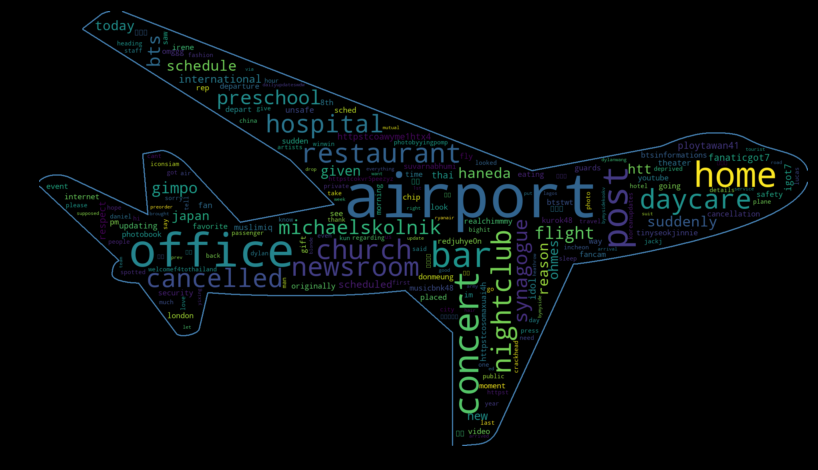

In [169]:
drawWordCloud(' '.join([' '.join(t) for ts in positive_tweets.values() for t in ts]), 
      'Positive tweets', 'Airplane_silhouette.png')

For the positive tweets, we see words such as *office*, which would point to many people are enjoying working from the airport.
Words like *bar*, *resturant*, and *nightclub* are also found, poniting to that most people enjoy being at these places.

## The least and most liked airports in the world

In [34]:
sentiment_avg = {
    airport: np.mean(values)
    for airport, values in sentiment.items()
}

In [37]:
sorted_sentiment = sorted(sentiment_avg.items(), key=lambda x: x[1])

In [95]:
def showAirportScore(airport: str):
    print(f'{airport}'.ljust(50), f'{sentiment_avg[airport]}')

First we can find the mean and standard deviation of the sentiment of the airports.

In [107]:
print('Mean and standard deviation sentiment of the airports: mean: {0:f}, sigma: {1:f}'
     .format(np.mean(list(sentiment_avg.values())), np.std(list(sentiment_avg.values()))))

Mean and standard deviation sentiment of the airports: mean: 6.274150, sigma: 0.200264


Now we can find the top five least and most liked airports in the world.

In [96]:
print('The least liked airports in the world')
for airport, _ in sorted_sentiment[:5]:
    showAirportScore(airport)

The least liked airports in the world
Dzaoudzi Pamandzi International Airport            5.605165685425686
Ouani Airport                                      5.605412113997115
Prince Said Ibrahim International Airport          5.617421637806638
Mohéli Bandar Es Eslam Airport                     5.617421637806638
Southdowns Airport                                 5.620871637806637


In [97]:
print('The most liked airports in the world')
for airport, _ in sorted_sentiment[::-1][:5]:
    showAirportScore(airport)

The most liked airports in the world
Pasni Airport                                      6.844752969252969
Doha International Airport                         6.842851937506938
Palmyra Airport                                    6.842851937506938
Bassel Al-Assad International Airport              6.832851937506938
Deir ez-Zor Airport                                6.832851937506938


In [98]:
busiest_airports = [
    'Hartsfield Jackson Atlanta International Airport',
    'Beijing Capital International Airport',
    'Dubai International Airport',
    'Los Angeles International Airport',
    'Tokyo Haneda International Airport',
    "Chicago O'Hare International Airport",
    'London Heathrow Airport',
    'Chek Lap Kok International Airport', # Hong Kong
    'Shanghai Pudong International Airport',
    'Indira Gandhi International Airport'
]

In [99]:
for airport in busiest_airports:
    showAirportScore(airport)

Hartsfield Jackson Atlanta International Airport   6.260418863913864
Beijing Capital International Airport              6.202427236652238
Dubai International Airport                        6.779575407370407
Los Angeles International Airport                  6.273325007215006
Tokyo Haneda International Airport                 5.934192453102453
Chicago O'Hare International Airport               6.210734430014429
London Heathrow Airport                            5.777641921134421
Chek Lap Kok International Airport                 6.18718961038961
Shanghai Pudong International Airport              6.191489660894661
Indira Gandhi International Airport                6.1794577994227975


In the output above, it can be seen that most of the busiest airports in the world is close to the average of all of the airports in the world, however all of them is slightly below.
London Heathrow Airport and Tokyo Haneda International Airport are quite low on the list, while Dubai International Airport is most more liked than all of the other busy airports.

## Exporting results

In [108]:
import csv

In [126]:
with open('./output/airport_sentiment.csv', 'w', encoding='utf-8', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter='\t')
    writer.writerow(('Airport', 'Sentiment'))
    for row in sorted_sentiment:
        writer.writerow(row)

In [147]:
with open('./output/sentiment_all.txt', 'w', encoding='utf-8') as f:
    for value in sorted(sentiment_all):
        if value < 10 and value != 0:
            f.write(str(value) + '\n')